# 🧠 Qwen2.5 Brain MRI Disease Diagnosis

Predict disease based on clinical history and image findings using Qwen2.5.

## 1. Setup & Imports

In [1]:
import os, json, base64, sys
from openai import OpenAI
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def encode_image_to_data_uri(path: str) -> str:
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode('utf-8')
    return f"data:image/png;base64,{b64}"

DATASET_DIR = "VLM-Seminar25-Dataset/nova_brain"
IMAGES_DIR = os.path.join(DATASET_DIR, "images")
ANNOT_PATH = os.path.join(DATASET_DIR, "annotations.json")
RESULTS_DIR = "../results/nova_brain/diagnosis"
os.makedirs(RESULTS_DIR, exist_ok=True)

with open(ANNOT_PATH, "r") as f:
    annotations = json.load(f)
case_ids = list(annotations.keys())

load_dotenv(dotenv_path="../config/user.env")
api_key = os.environ.get("NEBIUS_API_KEY")
client = OpenAI(base_url="https://api.studio.nebius.com/v1/", api_key=api_key)

In [2]:
do_new_inference = True

## 2. Model Inference

In [11]:
diagnosis_results = []
if do_new_inference:
    for case_id in tqdm(case_ids):
        case = annotations[case_id]
        clinical_history = case.get("clinical_history", "")
        findings = []
        for img_name, img_info in case.get("image_findings", {}).items():
            findings.append(f"{img_name}: {img_info.get('caption', '')}")
        findings_str = " ".join(findings)
        prompt = f"Based on the clinical history: {clinical_history} and image findings: {findings_str}, provide your diagnosis for the disease. Output only the final diagnosis without any additional text or explanation, e.g: 'Tumefactive demyelination.'"
        
        completion = client.chat.completions.create(
            model="Qwen/Qwen2.5-VL-72B-Instruct",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt}
                    ],
                }
            ],
        )
        pred = completion.choices[0].message.content.strip()
        diagnosis_results.append({
            "case_id": case_id,
            "prediction": pred,
            "diagdifferential_diagnosisnosis":  case.get("differential_diagnosis", ""), 
            "final_diagnosis":  case.get("final_diagnosis", ""), 
            "prompt": prompt,
            "clinical_history": clinical_history,
            "findings": findings,
        })

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:15<00:00,  1.62it/s]


## 3. Save Model Predictions

In [12]:
if do_new_inference:
    with open(os.path.join(RESULTS_DIR, "qwen2_5_diagnosis_results_oneshot.json"), "w") as f:
        json.dump(diagnosis_results, f, indent=2)
    print("Saved diagnosis results.")

Saved diagnosis results.


Load results

In [14]:
with open(os.path.join(RESULTS_DIR, "qwen2_5_diagnosis_results_oneshot.json"), "r") as f:
    diagnosis_results = json.load(f)
print(f"Number of cases diagnosed: {len(diagnosis_results)}")

Number of cases diagnosed: 25


In [17]:
diagnosis_results

[{'case_id': 'case0061',
  'prediction': 'Colloid cyst',
  'diagdifferential_diagnosisnosis': 'Central neurocytoma; Central neurocytoma; Subependymoma; Ependymoma; Subependymal giant cell astrocytoma',
  'final_diagnosis': 'Central neurocytoma',
  'prompt': "Based on the clinical history: A 30-year-old patient presented to the emergency department with 3 days history of headache, nausea and vomiting. Memory loss and disorientation in time and space were reported, without other neurological manifestations. and image findings: case0061_001.png: Axial contrast-enhanced T1 3D sequence shows an isointense mass and slight enhancement. case0061_002.png: Axial T2 gradient image shows a small hypointense area within the intraventricular mass, compatible with calcification., provide your diagnosis for the disease. Output only the final diagnosis without any additional text or explanation, e.g: 'Tumefactive demyelination.'",
  'clinical_history': 'A 30-year-old patient presented to the emergency 

## 4. Evaluation & Metrics

USing LLM

In [ ]:
llm_eval_results = []

# compare to final or differential diagnosis
compare_to = "final_diagnosis"  #  "diagdifferential_diagnosisnosis" or "final_diagnosis"

for x in tqdm(diagnosis_results):
    pred = x["prediction"]
    gt = x[compare_to]
    prompt = (
        "You are a medical expert. Given the ground truth diagnosis and the predicted diagnosis, determine whether it is correct 1 or not 0. So 1 if the predicted daignosis is the same as the gt. Think about your answer internally."
        "E.g: if ground truth: 'Central neurocytoma' and the prediciton: 'Colloid cyst', then the score is 0, because they are not the same.\n\n"
        "Return only the score as a integer.\n\n"
        f"Ground truth diagnosis : {pred}\n"
        f"Prediction: {pred}\n"
        "Score:"
    )
    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-VL-72B-Instruct",
        messages=[
            {"role": "user", "content": prompt}
        ],
    )
    score_str = completion.choices[0].message.content.strip()
    try:
        score = float(score_str)
    except Exception:
        score = None

    llm_eval_results.append({
        "case_id": x["case_id"],
        "ground_truth": gt,
        "prediction": pred,
        "llm_score": score,
    })

# Save LLM evaluation results TODO change to name_second if you want to use the second set
llm_json_path = os.path.join(RESULTS_DIR, f"llm_eval_scores_{compare_to}.json")
with open(llm_json_path, "w") as f:
    json.dump(llm_eval_results, f, indent=2)
print(f"Saved per-image LLM evaluation results to {llm_json_path}")

100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

Saved per-image LLM evaluation results to ../results/nova_brain/diagnosis\llm_eval_scores_final_diagnosis.json


In [19]:
llm_eval_results

[{'case_id': 'case0061',
  'ground_truth': 'Central neurocytoma',
  'prediction': 'Colloid cyst',
  'llm_score': 1.0},
 {'case_id': 'case0246',
  'ground_truth': 'Fahr’s syndrome',
  'prediction': "Wilson's disease.",
  'llm_score': 1.0},
 {'case_id': 'case0115',
  'ground_truth': 'Pyogenic brain abscess with intraventricular rupture',
  'prediction': 'Brain abscess and ventriculitis due to Campylobacter rectus.',
  'llm_score': 1.0},
 {'case_id': 'case0088',
  'ground_truth': 'Diffuse large B-cell lymphoma in the dura  with disseminated disease',
  'prediction': 'Meningioma.',
  'llm_score': 1.0},
 {'case_id': 'case0034',
  'ground_truth': 'Epidermoid cyst',
  'prediction': 'Normal Pressure Hydrocephalus',
  'llm_score': 1.0},
 {'case_id': 'case0005',
  'ground_truth': 'Basal ganglia calcifications secondary to hypoparathyroidism',
  'prediction': "Wilson's disease.",
  'llm_score': 1.0},
 {'case_id': 'case0080',
  'ground_truth': 'Methylmalonic acidaemia (MMA)',
  'prediction': 'Meth

PLot results

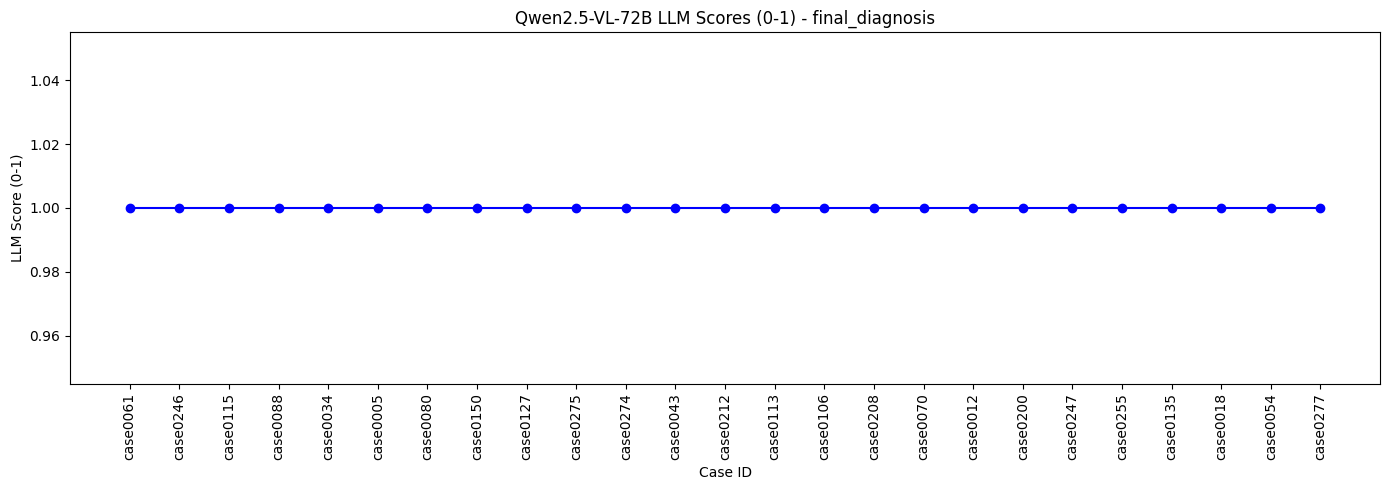

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))

scores = [x.get("llm_score", 0) for x in llm_eval_results]
xaxis = [x.get("case_id", "") for i, x in enumerate(llm_eval_results)]
plt.plot(xaxis, scores, marker='o', linestyle='-', color='b', label='')

plt.xticks(rotation=90)
plt.xlabel("Case ID")
plt.ylabel("LLM Score (0-1)")
plt.title(f"Qwen2.5-VL-72B LLM Scores (0-1) - {compare_to}")
plt.tight_layout()
#plt.legend()
plt.savefig(os.path.join(RESULTS_DIR, f"llm_scores_{compare_to}.png"))
plt.show()